In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("/kaggle/input/frauddataset/fraud_dataset.csv")

# Understanding of the Dataset

In [3]:
df.head()

,transaction_id,transaction_amount,location,merchant,age,gender,fraud_label
0,1,1000.0,New York,ABC Corp,35,M,0
1,2,500.0,Chicago,XYZ Inc,45,F,0
2,3,2000.0,Los Angeles,ABC Corp,28,M,1
3,4,1500.0,San Francisco,XYZ Inc,30,F,0
4,5,800.0,Chicago,ABC Corp,50,F,0


In [4]:
df.describe()

,transaction_id,transaction_amount,age,fraud_label
count,86.000000,86.000000,86.000000,86.000000
mean,43.500000,1623.430233,40.081395,0.186047
std,24.969982,799.196016,8.829383,0.391427
min,1.000000,500.000000,26.000000,0.000000
25%,22.250000,950.000000,32.250000,0.000000
50%,43.500000,1375.000000,39.500000,0.000000
75%,64.750000,2000.000000,47.750000,0.000000
max,86.000000,4000.000000,56.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      86 non-null     int64  
 1   transaction_amount  86 non-null     float64
 2   location            86 non-null     object 
 3   merchant            86 non-null     object 
 4   age                 86 non-null     int64  
 5   gender              86 non-null     object 
 6   fraud_label         86 non-null     int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 4.8+ KB


In [6]:
df.fraud_label.value_counts()

fraud_label
0    70
1    16
Name: count, dtype: int64

# Feature Engineering

In [7]:
ohe = OneHotEncoder(sparse=False)

In [8]:
ohe.fit(df[['merchant']])
ohe_merchant = ohe.transform(df[['merchant']])
ohe.get_feature_names_out()

array(['merchant_ABC Corp', 'merchant_XYZ Inc'], dtype=object)

In [9]:
df[ohe.get_feature_names_out()] = ohe_merchant

In [10]:
ohe.fit(df[['location']])
ohe_location = ohe.transform(df[['location']])
ohe.get_feature_names_out()

array(['location_Chicago', 'location_Los Angeles', 'location_New York',
       'location_San Francisco'], dtype=object)

In [11]:
df[ohe.get_feature_names_out()] = ohe_location

In [12]:
ohe.fit(df[['gender']])
ohe_gender = ohe.transform(df[['gender']])
ohe.get_feature_names_out()

array(['gender_F', 'gender_M'], dtype=object)

In [13]:
df[ohe.get_feature_names_out()] = ohe_gender

In [14]:
df_learn = df.loc[:,~df.columns.isin(['location', 'merchant','gender'])]
df_learn

,transaction_id,transaction_amount,age,fraud_label,merchant_ABC Corp,merchant_XYZ Inc,location_Chicago,location_Los Angeles,location_New York,location_San Francisco,gender_F,gender_M
0,1,1000.0,35,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,500.0,45,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3,2000.0,28,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4,1500.0,30,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,5,800.0,50,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
81,82,1500.0,31,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
82,83,2800.0,50,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
83,84,1350.0,28,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
84,85,920.0,47,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [15]:
correlation = df_learn.corr()

<Axes: >

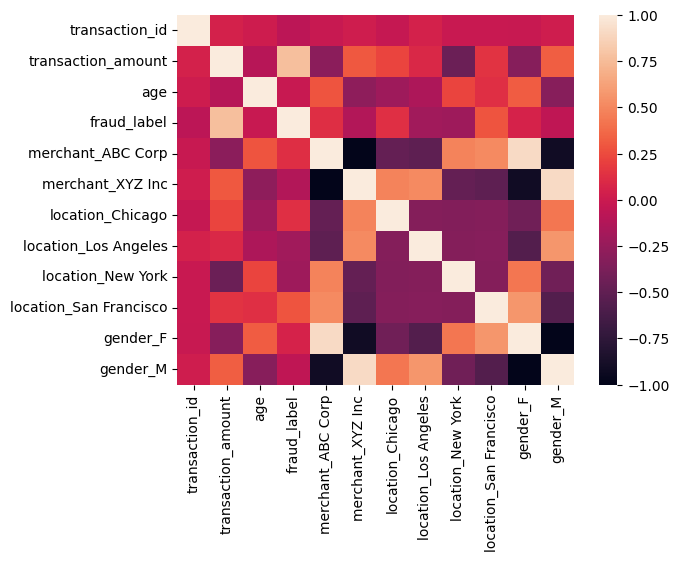

In [16]:
sns.heatmap(correlation)

In [17]:
x = df_learn.drop(['fraud_label'], axis=1)
y = df_learn['fraud_label']

# Balancing the samples

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
under_sampler = RandomUnderSampler()
x_res, y_res = under_sampler.fit_resample(x, y)

x_res.shape,y_res.shape

from collections import Counter 
print('Original dataset shape {}'.format(Counter(y))) 
print('Resampled dataset shape {}'.format(Counter(y_res)))


Original dataset shape Counter({0: 70, 1: 16})
Resampled dataset shape Counter({0: 16, 1: 16})


In [20]:
x_train,x_test,y_train,y_test=train_test_split(x_res, y_res, test_size=0.2, random_state=42)

In [21]:
print(x_train.shape) 
print(y_train.shape)

(25, 11)
(25,)


# Implementing Decision Tree

In [22]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [23]:
predicted_train = clf.predict(x_train)
predicted_test = clf.predict(x_test)

In [24]:
predicted_train

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0])

In [25]:
predicted_test

array([1, 0, 1, 1, 0, 0, 1])

# Checking feature importances

In [26]:
clf.feature_importances_

array([0.        , 0.85207101, 0.14792899, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [27]:
f_imp_list = list(zip(x_train.columns, clf.feature_importances_))
f_imp_list

[('transaction_id', 0.0),
 ('transaction_amount', 0.8520710059171598),
 ('age', 0.1479289940828402),
 ('merchant_ABC Corp', 0.0),
 ('merchant_XYZ Inc', 0.0),
 ('location_Chicago', 0.0),
 ('location_Los Angeles', 0.0),
 ('location_New York', 0.0),
 ('location_San Francisco', 0.0),
 ('gender_F', 0.0),
 ('gender_M', 0.0)]

In [28]:
for tup in f_imp_list:
    if tup[1] == 0.0:
        f_imp_list.remove(tup)
f_imp_list

[('transaction_amount', 0.8520710059171598),
 ('age', 0.1479289940828402),
 ('merchant_XYZ Inc', 0.0),
 ('location_Los Angeles', 0.0),
 ('location_San Francisco', 0.0),
 ('gender_M', 0.0)]

In [29]:
new_f_columns = [f_imp_list[i][0] for i in range(len(f_imp_list))]
new_f_columns

['transaction_amount',
 'age',
 'merchant_XYZ Inc',
 'location_Los Angeles',
 'location_San Francisco',
 'gender_M']

In [30]:
df_learn_new = df_learn[new_f_columns].copy()
df_learn_new

,transaction_amount,age,merchant_XYZ Inc,location_Los Angeles,location_San Francisco,gender_M
0,1000.0,35,0.0,0.0,0.0,1.0
1,500.0,45,1.0,0.0,0.0,0.0
2,2000.0,28,0.0,1.0,0.0,1.0
3,1500.0,30,1.0,0.0,1.0,0.0
4,800.0,50,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
81,1500.0,31,1.0,1.0,0.0,1.0
82,2800.0,50,0.0,0.0,1.0,0.0
83,1350.0,28,1.0,0.0,0.0,1.0
84,920.0,47,0.0,0.0,0.0,0.0


# Using Grid Search to find better Hyperparameters

In [31]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': list(range(2, 10, 1)),
    'min_samples_leaf': list(range(1, 10))
}

In [32]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

In [33]:
grid_search.fit(x_train, y_train) 

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(error_score='raise', estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy', verbose=1)

In [34]:
best_params = grid_search.best_params_
print(best_params)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3}
